In [ ]:
%matplotlib widget
import pickle
import matplotlib.pyplot as plt
import numpy as np
from math import cos, radians, sqrt
import pandas as pd

In [ ]:
K_MEAN_MIN_170 = 170
K_MEAN_MAX_350 = 350

K_MEAN_MIN_250 = 250
K_MEAN_MAX_450 = 450

K_MEAN_MIN_350 = 350
K_MEAN_MAX_550 = 550


L_MIN_170 = 250 * 2
L_MIN_250 = 350 * 2
L_MIN_350 = 500 * 2

L_MIN_500 = 500
L_MIN_700 = 700
L_MIN_1000 = 1000

START_TIME = "00:00:00"
END_TIME = "23:00:00"
MINUTE_INTERVAL = 10

# San Francisco square
DATA_SQUARE = { 
                "max_lat": 37.86499,
                "min_lon": -122.53304,
                "min_lat": 37.68481,
                "max_lon": -122.30576
                }

DATA_CENTER = {
    "lat": 37.7749,  # Latitude of San Francisco
    "lon": -122.4194  # Longitude of San Francisco
}

POI_LAT = DATA_CENTER["lat"]
POI_LON = DATA_CENTER["lon"]

working_days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]


In [ ]:
FIGURES_PATH = "Figures/"

In [4]:
def load_object(file_path, encoding=None):
    """
    To be used after calling save_object().
    Loads a python object that was pickled with save_object()

    :param str file_path: Path to the pickled
    :param str encoding: None or type of file encoding
    :return: None if load fails, else the pickled object
    :rtype: None if fails or type of objected pickled with save_object() 
    """
    
    if file_path is not None:

        with open(file_path, 'rb') as file:

            if encoding is not None:
                return pickle.load(file, encoding='latin1')
            else:
                return pickle.load(file)

    return None

In [5]:
def split_by_area(data_square, target_area_m2):
    """
    Given a square of coordinates data_square, with a target area size in square meters, calculates smaller squares inside data_square.
    Retruns a list of squares inside data_square.
    """
    
    def meters_to_degrees(lat, target_area_m2):
        """
        Computes the coordinates for a target area in square meters.
            - 1° of latitude is approximately 111,000 meters
            - 1° of longitude is approximately 111,320 meters at equator times cos(lat)
        """
        side_m = sqrt(target_area_m2)
        deg_lat = side_m / 111_000
        deg_lon = side_m / (111_320 * cos(radians(lat)))
        return deg_lat, deg_lon

    lat_max = data_square["max_lat"]
    lat_min = data_square["min_lat"]
    lon_min = data_square["min_lon"]
    lon_max = data_square["max_lon"]

    center_lat = (lat_max + lat_min) / 2
    delta_lat, delta_lon = meters_to_degrees(center_lat, target_area_m2)

    lat = lat_min
    squares = []

    while lat < lat_max:
        next_lat = min(lat + delta_lat, lat_max)
        lon = lon_min
        while lon < lon_max:
            next_lon = min(lon + delta_lon, lon_max)
            squares.append({
                "min_lat": lat,
                "max_lat": next_lat,
                "min_lon": lon,
                "max_lon": next_lon
            })
            lon = next_lon
        lat = next_lat

    return squares

In [6]:
def get_grid_for_point(lat, lon, grid_squares):
    for idx, square in enumerate(grid_squares):
        if (square['min_lat'] <= lat <= square['max_lat'] and
            square['min_lon'] <= lon <= square['max_lon']):
            return idx
    return None

In [7]:
def plot_traffic_one_day_for_poi(lat, lon, grid_squares, daily_dict, protected_dict, day, lmin="300"):
    grid_idx = get_grid_for_point(lat, lon, grid_squares)
    if grid_idx is None:
        print("Location is not within any grid square.")
        return

    plt.figure(figsize=(14, 7))

    # Plot original data for the specific day
    if day in daily_dict:
        traffic_map = daily_dict[day]["traffic_map"]
        if traffic_map is not None:
            aggregated_time_series = np.sum(traffic_map[grid_idx, :, :], axis=1)
            time_steps = np.arange(len(aggregated_time_series))
            plt.plot(time_steps, aggregated_time_series, marker='o', label=f"{day} original")

    # Plot protected data for the specific day
    if day in protected_dict:
        traffic_map = protected_dict[day]["traffic_map"]
        if traffic_map is not None:
            aggregated_time_series = np.sum(traffic_map[grid_idx, :, :], axis=1)
            time_steps = np.arange(len(aggregated_time_series))
            plt.plot(time_steps, aggregated_time_series, marker='x', label=f"{day} protected")

    num_steps = len(aggregated_time_series)
    time_labels = [f"{(t * 10) // 60:02}:{(t * 10) % 60:02}" for t in range(num_steps)]
    plt.xticks(ticks=np.arange(0, num_steps, 6), labels=time_labels[::6], rotation=45) 

    plt.title(f"Aggregated Traffic for POI at ({lat}, {lon}) on {day} - Lmin: {lmin}")
    plt.xlabel("Time Steps (1 point = 10 min)")
    plt.ylabel("Trajectory points in cell")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.save(f"{FIGURES_PATH}{day}_{}")

In [1]:
def split_tensor_by_weekday(tensor, unique_dates):
    """
    Splits a 3D tensor [grid, time, day] into 7 weekday tensors.
    Each weekday tensor includes only the days in the tensor corresponding to that weekday.

    Returns:
        weekday_dict: {
            0: tensor for Mondays,
            1: tensor for Tuesdays,
            ...
            6: tensor for Sundays
        }
    """
    weekday_dict = {i: [] for i in range(7)}  # 0 = Monday, ..., 6 = Sunday

    for z, date_str in enumerate(unique_dates):
        weekday = pd.to_datetime(date_str).weekday()
        weekday_dict[weekday].append(tensor[:, :, z])

    # Stack each list into a 3D tensor again (grid, time, num_days)
    for weekday in weekday_dict:
        if weekday_dict[weekday]:
            weekday_dict[weekday] = np.stack(weekday_dict[weekday], axis=2)
        else:
            weekday_dict[weekday] = None

    return weekday_dict

Data loading

In [ ]:
flow_map_500 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_flow_map_{L_MIN_500}")
flow_map_700 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_flow_map_{L_MIN_700}")
flow_map_1000 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_flow_map_{L_MIN_700}")

point_map_500 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_traffic_map_{L_MIN_500}")
point_map_700 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_traffic_map_{L_MIN_700}")
point_map_1000 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_traffic_map_{L_MIN_1000}")

avg_trav_500 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_avgtrav_map_{L_MIN_500}")
avg_trav_700 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_avgtrav_map_{L_MIN_700}")
avg_trav_1000 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_avgtrav_map_{L_MIN_1000}")

intervals_500 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_intervals_map_{L_MIN_500}")
intervals_700 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_intervals_map_{L_MIN_700}")
intervals_1000 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_intervals_map_{L_MIN_1000}")

dates_500 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_dates_map_{L_MIN_500}")
# dates_700 = load_object("../datasets/PaperResults/traffic_maps/one_set_three_tensors/port_dates_map_700")
dates_1000 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_dates_map_{L_MIN_1000}")

In [ ]:
protected_flow_map_500 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_protected_flow_map_{L_MIN_500}")
protected_flow_map_700 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_protected_flow_map_{L_MIN_700}")
protected_flow_map_1000 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_protected_flow_map_{L_MIN_1000}")

protected_point_map_500 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_protected_traffic_map_{L_MIN_500}")
protected_point_map_700 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_protected_traffic_map_{L_MIN_700}")
protected_point_map_1000 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_protected_traffic_map_{L_MIN_1000}")

protected_avg_trav_500 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_protected_avgtrav_map_{L_MIN_500}")
protected_avg_trav_700 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_protected_avgtrav_map_{L_MIN_700}")
protected_avg_trav_1000 = load_object(f"../data/traffic_maps/one_set_three_tensors/sf_avgtrav_map_{L_MIN_1000}")

In [ ]:
weekday_avg_traversal_500 = split_tensor_by_weekday(avg_trav_500, dates_500)
weekday_flow_500 = split_tensor_by_weekday(flow_map_500, dates_500)
weekday_points_500 = split_tensor_by_weekday(point_map_500, dates_500)


protected_weekday_avg_traversal_500 = split_tensor_by_weekday(protected_avg_trav_500, dates_500)
protected_weekday_flow_500 = split_tensor_by_weekday(protected_flow_map_500, dates_500)
protected_weekday_points_500 = split_tensor_by_weekday(protected_point_map_500, dates_500)

In [ ]:
weekday_avg_traversal_700 = split_tensor_by_weekday(avg_trav_700, dates_500)
weekday_flow_700 = split_tensor_by_weekday(flow_map_700, dates_500)
weekday_points_700 = split_tensor_by_weekday(point_map_700, dates_500)

protected_weekday_avg_traversal_700 = split_tensor_by_weekday(protected_avg_trav_700, dates_500)
protected_weekday_flow_700 = split_tensor_by_weekday(protected_flow_map_700, dates_500)
protected_weekday_points_700 = split_tensor_by_weekday(protected_point_map_700, dates_500)

In [ ]:
weekday_avg_traversal_1000 = split_tensor_by_weekday(avg_trav_1000, dates_1000)
weekday_flow_1000 = split_tensor_by_weekday(flow_map_1000, dates_1000)
weekday_points_1000 = split_tensor_by_weekday(point_map_1000, dates_1000)

protected_weekday_avg_traversal_1000 = split_tensor_by_weekday(protected_avg_trav_1000, dates_1000)
protected_weekday_flow_1000 = split_tensor_by_weekday(protected_flow_map_1000, dates_1000)
protected_weekday_points_1000 = split_tensor_by_weekday(protected_point_map_1000, dates_1000)

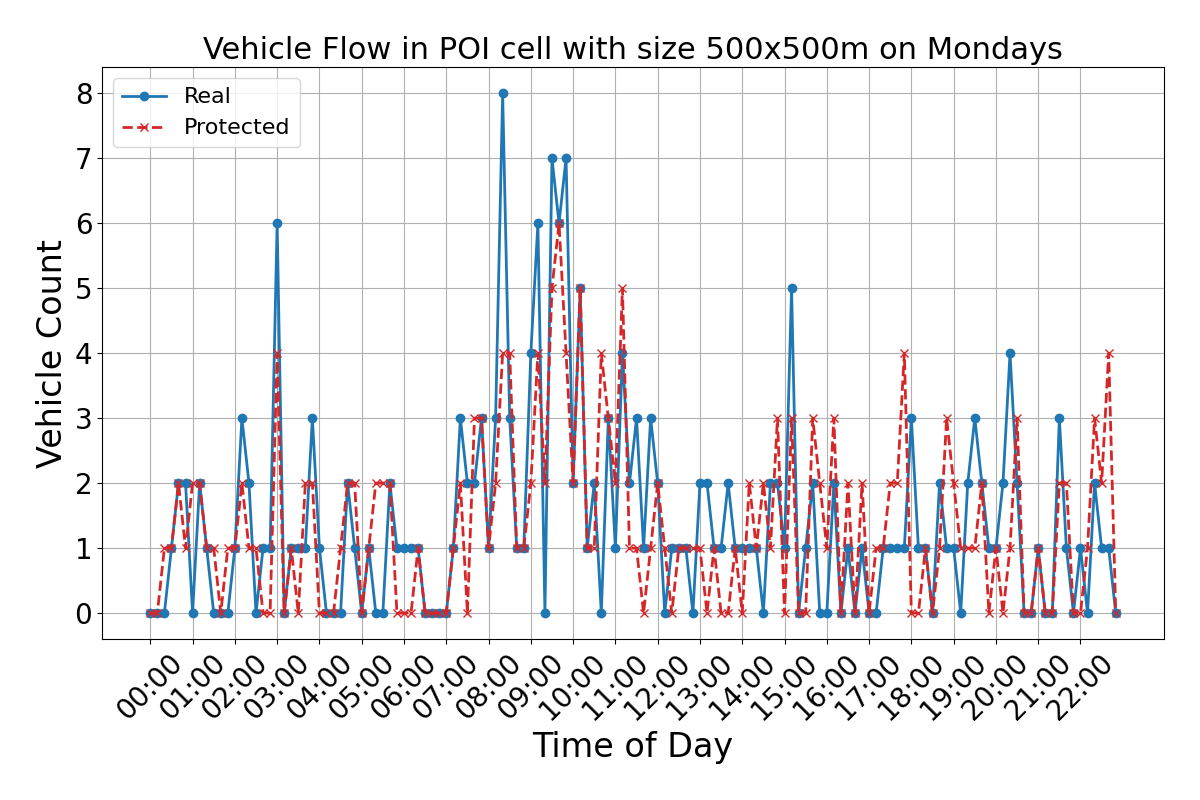

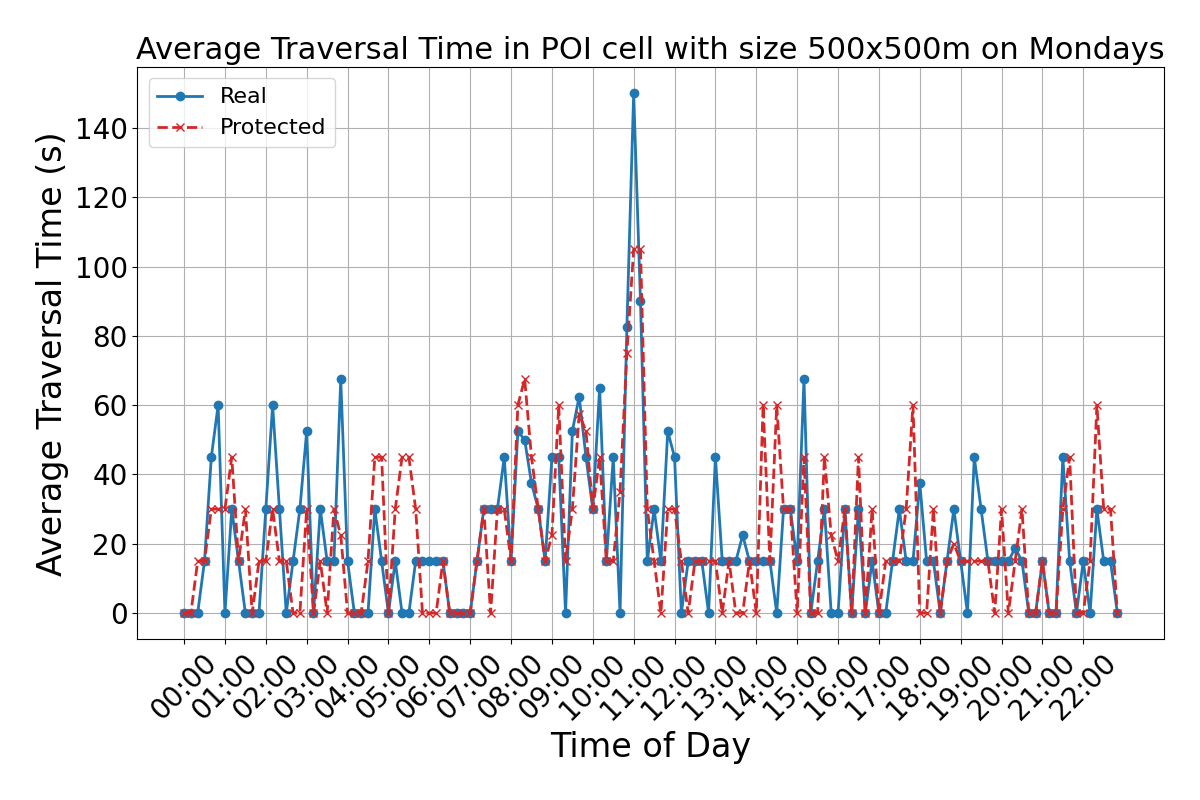

In [ ]:
def plot_flow_and_traversal_500(
    grid_idx,
    weekday,
    intervals,
    weekday_flow_500,
    protected_weekday_flow_500,
    weekday_avg_traversal_500,
    protected_weekday_avg_traversal_500,
):

    flow_orig = weekday_flow_500.get(weekday)
    flow_prot = protected_weekday_flow_500.get(weekday)
    trav_orig = weekday_avg_traversal_500.get(weekday)
    trav_prot = protected_weekday_avg_traversal_500.get(weekday)

    # Aggregate
    flow_o = np.sum(flow_orig[grid_idx, :, :], axis=1)
    flow_p = np.sum(flow_prot[grid_idx, :, :], axis=1)

    trav_o = np.mean(trav_orig[grid_idx, :, :], axis=1)
    trav_p = np.mean(trav_prot[grid_idx, :, :], axis=1)

    x = np.arange(len(flow_o))
    time_labels = [t.strftime("%H:%M") for t in intervals]
    ticks = np.arange(0, len(x), 6)

    weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    day_name = weekday_names[weekday]

    # === Plot 1: Vehicle Flow ===
    plt.figure(figsize=(12, 8))
    plt.rcParams.update({
        'font.size': 24,
        'axes.titlesize': 22,
        'axes.labelsize': 24,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.fontsize': 16,
        'figure.titlesize': 20,
        'axes.grid': True,
        'axes.grid.which': 'major'
    })

    plt.plot(x, flow_o, label='Real', color='tab:blue', linestyle='-', linewidth=2, marker='o')
    plt.plot(x, flow_p, label='Protected', color='tab:red', linestyle='--', linewidth=2, marker='x')
    plt.xticks(ticks=ticks, labels=time_labels[::6], rotation=45)
    plt.title(f"Vehicle Flow in POI cell with size 500x500m on {day_name}s")
    plt.xlabel("Time of Day")
    plt.ylabel("Vehicle Count")
    plt.legend()
    plt.legend(loc='upper left')

    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{FIGURES_PATH}sf_{day_name}_vehicle_flow.pdf", format="pdf", bbox_inches='tight', dpi=300)

    # === Plot 2: Avg Traversal Time ===
    plt.figure(figsize=(12, 8))
    plt.plot(x, trav_o, label='Real', color='tab:blue', linestyle='-', linewidth=2, marker='o')
    plt.plot(x, trav_p, label='Protected', color='tab:red', linestyle='--', linewidth=2, marker='x')
    plt.xticks(ticks=ticks, labels=time_labels[::6], rotation=45)
    plt.title(f"Average Traversal Time in POI cell with size 500x500m on {day_name}s")
    plt.xlabel("Time of Day")
    plt.ylabel("Average Traversal Time (s)")
    plt.legend()
    plt.legend(loc='upper left')

    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(f"{FIGURES_PATH}sf_{day_name}_avg_trav_time.pdf", format="pdf", bbox_inches='tight', dpi=300)

plot_flow_and_traversal_500(
    grid_idx=0, # Only one square
    weekday=0,  # Monday
    intervals=intervals_500,
    weekday_flow_500=weekday_flow_500,
    protected_weekday_flow_500=protected_weekday_flow_500,
    weekday_avg_traversal_500=weekday_avg_traversal_500,
    protected_weekday_avg_traversal_500=protected_weekday_avg_traversal_500,
)

In [ ]:
def compute_mean_waiting_in_hour_range(weekday_avg_traversal, intervals, start_hour=8, end_hour=9):
    """
    Compute mean waiting time per weekday between specific hourly range.
    Only includes non-zero traversal values.
    """
    weekday_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    result = {}

    # Map intervals to hour values
    interval_hours = np.array([t.hour + t.minute / 60.0 for t in intervals])
    mask = (interval_hours >= start_hour) & (interval_hours < end_hour)

    for weekday in range(7):
        tensor = weekday_avg_traversal.get(weekday)
        if tensor is None or not np.any(mask):
            result[weekday_names[weekday]] = np.nan
            continue

        selected = tensor[:, mask, :] if tensor.ndim == 3 else tensor[mask, :]
        selected_vals = tensor[:, mask, :].reshape(tensor.shape[0], -1)[:, :].flatten()
        nonzero_vals = selected_vals[selected_vals > 0]

        result[weekday_names[weekday]] = np.mean(nonzero_vals) if nonzero_vals.size > 0 else np.nan

    return result

start = 8

stop = 9
# Run for 8:00 to 9:00
mean_500_hr = compute_mean_waiting_in_hour_range(weekday_avg_traversal_500, intervals_500, start, stop)
mean_700_hr = compute_mean_waiting_in_hour_range(weekday_avg_traversal_700, intervals_700, start, stop)
mean_1000_hr = compute_mean_waiting_in_hour_range(weekday_avg_traversal_1000, intervals_1000, start, stop)

protected_mean_500_hr = compute_mean_waiting_in_hour_range(protected_weekday_avg_traversal_500, intervals_500, start, stop)
protected_mean_700_hr = compute_mean_waiting_in_hour_range(protected_weekday_avg_traversal_700, intervals_700, start, stop)
protected_mean_1000_hr = compute_mean_waiting_in_hour_range(protected_weekday_avg_traversal_1000, intervals_1000, start, stop)

mean_waiting_hour_df = pd.DataFrame({
    "500m": mean_500_hr,
    "700m": mean_700_hr,
    "1000m": mean_1000_hr
}).reset_index().rename(columns={"index": "Weekday"})

protected_mean_waiting_hour_df = pd.DataFrame({
    "500m": protected_mean_500_hr,
    "700m": protected_mean_700_hr,
    "1000m": protected_mean_1000_hr
}).reset_index().rename(columns={"index": "Weekday"})

In [ ]:
mean_waiting_hour_df["500m"]

In [ ]:
mean_waiting_hour_df["700m"]

In [ ]:
mean_waiting_hour_df["1000m"]

In [ ]:
protected_mean_waiting_hour_df["500m"]

In [ ]:
protected_mean_waiting_hour_df["700m"]

In [ ]:
protected_mean_waiting_hour_df["1000m"]